# F1 Fastest Lap Machine Learning Models

## Identifying Previous F1 Meetings

In [243]:
import requests
import pandas as pd

url = "https://api.openf1.org/v1/meetings"
response = requests.get(url)

if response.status_code == 200:
    f1_meetings = response.json()
    print(f1_meetings)
else:
    print(f"Failed to retrieve data: {response.status_code}")



current_meeting_response = requests.get(url + "?meeting_key=latest")

if current_meeting_response.status_code == 200:
    current_meeting = current_meeting_response.json()[0]
else:
    print(f"Failed to retrieve data: {current_meeting_response.status_code}")

f1_meetings = [meeting for meeting in f1_meetings if meeting['meeting_key'] != current_meeting['meeting_key'] and "Grand Prix" in meeting['meeting_name']]

# Convert the list of meetings to a pandas DataFrame
f1_meetings_df = pd.DataFrame(f1_meetings)

print(f1_meetings_df.head())
print(f1_meetings_df.shape)


[{'meeting_name': 'Pre-Season Testing', 'meeting_official_name': 'FORMULA 1 ARAMCO PRE-SEASON TESTING 2023', 'location': 'Sakhir', 'country_key': 36, 'country_code': 'BRN', 'country_name': 'Bahrain', 'circuit_key': 63, 'circuit_short_name': 'Sakhir', 'date_start': '2023-02-23T07:00:00+00:00', 'gmt_offset': '03:00:00', 'meeting_key': 1140, 'year': 2023}, {'meeting_name': 'Bahrain Grand Prix', 'meeting_official_name': 'FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2023', 'location': 'Sakhir', 'country_key': 36, 'country_code': 'BRN', 'country_name': 'Bahrain', 'circuit_key': 63, 'circuit_short_name': 'Sakhir', 'date_start': '2023-03-03T11:30:00+00:00', 'gmt_offset': '03:00:00', 'meeting_key': 1141, 'year': 2023}, {'meeting_name': 'Saudi Arabian Grand Prix', 'meeting_official_name': 'FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2023', 'location': 'Jeddah', 'country_key': 153, 'country_code': 'KSA', 'country_name': 'Saudi Arabia', 'circuit_key': 149, 'circuit_short_name': 'Jeddah', 'date_start': '2023-0

## Compiling Race Features

In [244]:
def get_year_feature_names(df):
    year_dummies = pd.get_dummies(df['year'], prefix='year').astype(int)
    return list(year_dummies.columns)

def get_circuit_feature_names(df):
    circuit_dummies = pd.get_dummies(df['circuit_key'], prefix='circuit').astype(int)
    return list(circuit_dummies.columns)

year_feature_names = get_year_feature_names(f1_meetings_df)
circuit_feature_names = get_circuit_feature_names(f1_meetings_df)
qualifying_feature_names = ['qualifying_fastest_lap', 'qualifying_average_lap', 'qualifying_median_lap', 'qualifying_std_dev', 'qualifying_num_laps']

input_feature_names = year_feature_names + circuit_feature_names + qualifying_feature_names
output_feature_name = "race_fastest_lap"

In [245]:


def compile_features(meeting_df):
    # Function to get all sessions for a given meeting
    def get_sessions(meeting_key):
        sessions_url = f"https://api.openf1.org/v1/sessions?meeting_key={meeting_key}"
        sessions_response = requests.get(sessions_url)
        if sessions_response.status_code == 200:
            return sessions_response.json()
        return []

    # Add a new column for the sessions
    meeting_df['sessions'] = meeting_df['meeting_key'].apply(get_sessions)

    # Function to get session keys for Race and Qualifying
    def get_session_keys(sessions, session_name):
        for session in sessions:
            if session['session_name'] == session_name:
                return session['session_key']
        return None

    # Add new columns for race_session_key and qualifying_session_key
    meeting_df['race_session_key'] = meeting_df['sessions'].apply(lambda x: get_session_keys(x, 'Race'))
    meeting_df['qualifying_session_key'] = meeting_df['sessions'].apply(lambda x: get_session_keys(x, 'Qualifying'))


    # Add Circuit Features from main f1_meetings_df
    for circuit_feature in circuit_feature_names:
        meeting_df[circuit_feature] = (meeting_df['circuit_key'] == circuit_feature.split('_')[-1]).astype(int)

    # Add Year Features from main f1_meetings_df
    for year_feature in year_feature_names:
        meeting_df[year_feature] = (meeting_df['year'] == int(year_feature.split('_')[-1])).astype(int)

    # Add Qualifying Lap Statistics
    def get_lap_statistics(session_key):
        lap_url = f"https://api.openf1.org/v1/laps?session_key={session_key}"
        lap_response = requests.get(lap_url)
        if lap_response.status_code == 200:
            laps = [lap for lap in lap_response.json() if lap['lap_duration'] is not None]
            lap_durations = [lap['lap_duration'] for lap in laps]

            if lap_durations:
                fastest_lap = min(lap_durations)
                average_lap = sum(lap_durations) / len(lap_durations)
                median_lap = statistics.median(lap_durations)
                std_dev = statistics.stdev(lap_durations) if len(lap_durations) > 1 else 0
                num_laps = len(lap_durations)

                return {
                    'fastest_lap': fastest_lap,
                    'average_lap': average_lap,
                    'median_lap': median_lap,
                    'std_dev': std_dev,
                    'num_laps': num_laps
                }
        return {
            'fastest_lap': None,
            'average_lap': None,
            'median_lap': None,
            'std_dev': None,
            'num_laps': 0
        }

    stats_list = meeting_df['qualifying_session_key'].apply(get_lap_statistics)
    stats_df = pd.DataFrame(stats_list.tolist())
    stats_df = stats_df.add_prefix('qualifying_')
    qualifying_feature_names = list(stats_df.columns)

    meeting_df = pd.concat([meeting_df, stats_df], axis=1)

    feature_names = circuit_feature_names + year_feature_names + qualifying_feature_names

    return meeting_df, feature_names

    

In [246]:
# Apply the function to the F1 Meetings DataFrame
f1_meetings_df, feature_names = compile_features(f1_meetings_df)

## Race Output Variable

In [247]:
# Apply the function to each race session key and extract the fastest lap
f1_meetings_df['race_fastest_lap'] = f1_meetings_df['race_session_key'].apply(lambda x: get_lap_statistics(x)['fastest_lap'])

# Display the updated DataFrame
print(f1_meetings_df["race_fastest_lap"].head())


0     93.996
1     91.906
2     80.235
3    103.370
4     89.708
Name: race_fastest_lap, dtype: float64


## Predicting Race Fastest Laps with Multi-Layer Perceptrons

In [248]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define input features and output feature
input_features = f1_meetings_df[input_feature_names]
output_feature = f1_meetings_df[output_feature_name]

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

mlp_model = MLPRegressor(hidden_layer_sizes=(200, 100), activation='relu', solver='adam', random_state=42)

# Perform KFold cross-validation
for train_index, test_index in kf.split(input_features):
    X_train, X_test = input_features.iloc[train_index], input_features.iloc[test_index]
    y_train, y_test = output_feature.iloc[train_index], output_feature.iloc[test_index]
    
    # Train the model
    mlp_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = mlp_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average scores
average_mse = sum(mse_scores) / len(mse_scores)
average_r2 = sum(r2_scores) / len(r2_scores)

print("Average Mean Squared Error:", average_mse)
print("Average R^2 Score:", average_r2)


/home/patrick-personal/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/patrick-personal/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/patrick-personal/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/patrick-personal/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Average Mean Squared Error: 5.210734905387709
Average R^2 Score: 0.950073446319762


/home/patrick-personal/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Evaluate Model Performances

### Evaluate K-Fold Cross Validation

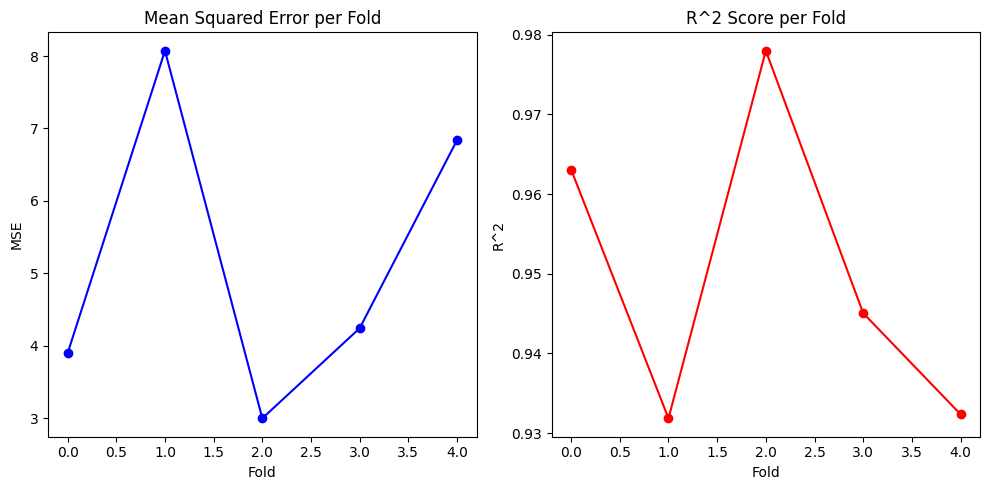

In [249]:

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 5))

# Plot MSE scores
plt.subplot(1, 2, 1)
plt.plot(mse_scores, marker='o', linestyle='-', color='b')
plt.title('Mean Squared Error per Fold')
plt.xlabel('Fold')
plt.ylabel('MSE')

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.plot(r2_scores, marker='o', linestyle='-', color='r')
plt.title('R^2 Score per Fold')
plt.xlabel('Fold')
plt.ylabel('R^2')

plt.tight_layout()
plt.show()

### Evaluate Feature Importancs

Mean Squared Error on Test Set: 3.898660346885681
R^2 Score on Test Set: 0.9630830403290515

Actual vs Predicted Fastest Laps:
   Actual Fastest Lap  Predicted Fastest Lap
0              79.813              80.466486
1              85.072              85.014160
2              67.012              70.497877
3              93.706              90.160537
4              89.708              92.108384
5              97.330              96.576518
6              72.486              73.966429
7              94.486              94.770046
8              74.165              73.010020


/home/patrick-personal/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


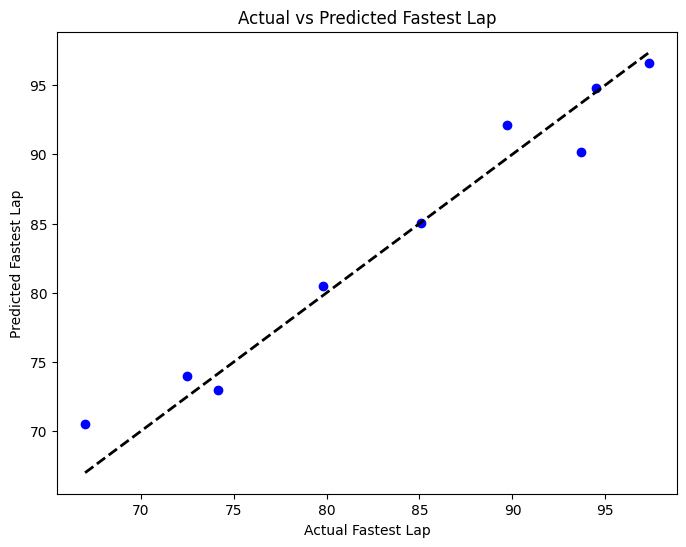

In [250]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features, output_feature, test_size=0.2, random_state=42
)

# Train the model
mlp_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error on Test Set:", mse)
print("R^2 Score on Test Set:", r2)

# Output the actual and predicted fastest laps for the test set
test_results = pd.DataFrame({
    'Actual Fastest Lap': y_test.values.flatten(),
    'Predicted Fastest Lap': y_pred.flatten()
})

print("\nActual vs Predicted Fastest Laps:")
print(test_results)

# residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Fastest Lap')
plt.ylabel('Predicted Fastest Lap')
plt.title('Actual vs Predicted Fastest Lap')
plt.show()



In [251]:
# Extract the current meeting data into a DataFrame
current_meeting_df = pd.DataFrame([current_meeting])

# Compile features for the current meeting
current_meeting_df, current_feature_names = compile_features(current_meeting_df)

# Ensure the current meeting DataFrame has the same columns as the training data
current_meeting_df = current_meeting_df[input_feature_names]

# Predict the fastest lap for the current meeting
current_meeting_prediction = mlp_model.predict(current_meeting_df)

print("Predicted Fastest Lap for the Current Meeting:", current_meeting_prediction[0])

Predicted Fastest Lap for the Current Meeting: 78.68618366113567


In [252]:
# Calculate feature importances using the trained MLP model
importances = mlp_model.coefs_[0].mean(axis=1)

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame({
    'Feature': input_feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importances)


Feature Importances:
                   Feature  Importance
29      qualifying_std_dev    0.014839
27  qualifying_average_lap    0.014191
30     qualifying_num_laps    0.011400
26  qualifying_fastest_lap    0.010057
28   qualifying_median_lap    0.005193
5                circuit_7    0.001433
2                circuit_2    0.000917
14              circuit_46    0.000699
12              circuit_23    0.000621
10              circuit_19    0.000462
17              circuit_61    0.000435
24             circuit_151    0.000404
23             circuit_150    0.000346
22             circuit_149    0.000189
9               circuit_15   -0.000183
19              circuit_65   -0.000238
3                circuit_4   -0.000281
6                circuit_9   -0.000361
7               circuit_10   -0.000367
1                year_2024   -0.000395
25             circuit_152   -0.000417
15              circuit_49   -0.000423
8               circuit_14   -0.000429
18              circuit_63   -0.000631
20  